In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, cross_val_predict
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [18]:
column_names=[
    'age', 'class', 'ind_code_det', 'occ_code_det', 'education', 'wage_hr', 'enroll_edu', 'marital',
    'ind_code_maj', 'occ_code_maj', 'race', 'hisp_origin', 'sex', 'lab_union', 'reason_unemp',
    'emp_status', 'cap_gain', 'cap_loss', 'dividend', 'tax_filer_stat', 'prev_res_area', 'prev_res_state',
    'fam_state', 'fam_state_sum', 'inst_weight', 'migr_change_msa', 'migr_change_reg', 'migr_move_msa', 'lived_1yr',
    'migr_sunbelt', 'num_ppl_worked', 'fam_members_u18', 'birth_dad', 'birth_mom', 'birth_self', 'citizenship',
    'employed_status', 'veteran_admin', 'veteran_benefit', 'weeks_worked', 'year', 'income']

train = pd.read_csv('census-income.data',header=None)
train.columns=column_names
test = pd.read_csv('census-income.test',header=None)
test.columns=column_names

train.drop(['migr_change_msa','migr_change_reg','migr_move_msa','migr_sunbelt'],axis = 1,inplace=True)
train.dropna(inplace=True)
test.drop(['migr_change_msa','migr_change_reg','migr_move_msa','migr_sunbelt'],axis = 1,inplace=True)
test.dropna(inplace=True)

train.head(2)

,age,class,ind_code_det,occ_code_det,education,wage_hr,enroll_edu,marital,ind_code_maj,occ_code_maj,...,birth_dad,birth_mom,birth_self,citizenship,employed_status,veteran_admin,veteran_benefit,weeks_worked,year,income
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.


In [19]:
predictors = [
    'age', 'class', 'ind_code_det', 'occ_code_det', 'education', 'wage_hr', 'enroll_edu', 'marital',
    'ind_code_maj', 'occ_code_maj', 'race', 'hisp_origin', 'sex', 'lab_union', 'reason_unemp',
    'emp_status', 'cap_gain', 'cap_loss', 'dividend', 'tax_filer_stat', 'prev_res_area', 'prev_res_state',
    'fam_state', 'fam_state_sum', 'inst_weight', 'lived_1yr',
    'num_ppl_worked', 'fam_members_u18', 'birth_dad', 'birth_mom', 'birth_self', 'citizenship',
    'employed_status', 'veteran_admin', 'veteran_benefit', 'weeks_worked', 'year']

In [20]:
categorical_predictors = [
    'class', 'ind_code_det', 'occ_code_det', 'education', 'enroll_edu', 'marital',
    'ind_code_maj', 'occ_code_maj', 'race', 'hisp_origin', 'sex', 'lab_union', 'reason_unemp',
    'emp_status', 'tax_filer_stat', 'prev_res_area', 'prev_res_state',
    'fam_state', 'fam_state_sum',  'lived_1yr', 'fam_members_u18', 'birth_dad', 
    'birth_mom', 'birth_self', 'citizenship',
    'employed_status', 'veteran_admin', 'veteran_benefit', 'year']

In [21]:
train['>50K'] = train['income'].apply(lambda x: 1 if x == ' 50000+.' else 0)
test['>50K'] = test['income'].apply(lambda x: 1 if x == ' 50000+.' else 0)

In [23]:
# See imbalanced dataset 
from collections import Counter
train_distr = Counter(train['>50K'])
test_distr = Counter(test['>50K'])
print(train_distr, test_distr)

Counter({0: 187141, 1: 12382}) Counter({0: 93576, 1: 6186})


In [24]:
# balance data
from sklearn.utils import resample
train_0 = train[train['>50K'] == 0]
train_1 = train[train['>50K'] == 1]
sampled_train_0 = resample(train_0, n_samples=int(0.08 * len(train_0)), random_state=1)
train = pd.concat([sampled_train_0, train_1])

test_0 = test[test['>50K'] == 0]
test_1 = test[test['>50K'] == 1]
sampled_test_0 = resample(test_0, n_samples=int(0.08 * len(test_0)), random_state=1)
test = pd.concat([sampled_test_0, test_1])

train_distr = Counter(train['>50K'])
test_distr = Counter(test['>50K'])
print(train_distr, test_distr)

Counter({0: 14971, 1: 12382}) Counter({0: 7486, 1: 6186})


In [27]:
X_train = train[predictors]
y_train = train['>50K']
X_test = test[predictors]
y_test = test['>50K']
X_train.head(2)

,age,class,ind_code_det,occ_code_det,education,wage_hr,enroll_edu,marital,ind_code_maj,occ_code_maj,...,fam_members_u18,birth_dad,birth_mom,birth_self,citizenship,employed_status,veteran_admin,veteran_benefit,weeks_worked,year
136487,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94
5507,22,Private,33,41,Some college but no degree,0,Not in universe,Never married,Retail trade,Handlers equip cleaners etc,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,94


In [28]:
# one-hot encoding 
combined_X = pd.concat([X_train, X_test], axis=0)
X_encoded = pd.get_dummies(combined_X, columns=categorical_predictors, dtype=int)
X_train_encoded = X_encoded.iloc[:len(X_train)]
X_test_encoded = X_encoded.iloc[len(X_train):]

# Feature Engineering

In [29]:
#Removing quasi-constant features
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0.01)  # 0.1 indicates 99% of observations approximately
sel.fit(X_train_encoded)  # fit finds the features with low variance
sum(sel.get_support())

189

In [30]:
sel_idx = X_train_encoded.columns[sel.get_support()]
sel_idx

Index(['age', 'wage_hr', 'cap_gain', 'cap_loss', 'dividend', 'inst_weight',
       'num_ppl_worked', 'weeks_worked', 'class_ Federal government',
       'class_ Local government',
       ...
       'employed_status_0', 'employed_status_1', 'employed_status_2',
       'veteran_admin_ No', 'veteran_admin_ Not in universe',
       'veteran_benefit_0', 'veteran_benefit_1', 'veteran_benefit_2',
       'year_94', 'year_95'],
      dtype='object', length=189)

In [31]:
# finally we can print the quasi-constant features
print(
    len([
        x for x in X_train_encoded.columns
        if x not in X_train_encoded.columns[sel.get_support()]
    ]))

[x for x in X_train_encoded.columns if x not in X_train_encoded.columns[sel.get_support()]]

284


['class_ Never worked',
 'class_ Without pay',
 'ind_code_det_1',
 'ind_code_det_3',
 'ind_code_det_5',
 'ind_code_det_6',
 'ind_code_det_7',
 'ind_code_det_8',
 'ind_code_det_9',
 'ind_code_det_10',
 'ind_code_det_13',
 'ind_code_det_14',
 'ind_code_det_15',
 'ind_code_det_16',
 'ind_code_det_17',
 'ind_code_det_18',
 'ind_code_det_19',
 'ind_code_det_20',
 'ind_code_det_21',
 'ind_code_det_22',
 'ind_code_det_23',
 'ind_code_det_26',
 'ind_code_det_27',
 'ind_code_det_28',
 'ind_code_det_36',
 'ind_code_det_38',
 'ind_code_det_40',
 'ind_code_det_46',
 'ind_code_det_48',
 'ind_code_det_49',
 'ind_code_det_51',
 'occ_code_det_1',
 'occ_code_det_6',
 'occ_code_det_9',
 'occ_code_det_13',
 'occ_code_det_14',
 'occ_code_det_15',
 'occ_code_det_20',
 'occ_code_det_21',
 'occ_code_det_22',
 'occ_code_det_24',
 'occ_code_det_25',
 'occ_code_det_27',
 'occ_code_det_30',
 'occ_code_det_32',
 'occ_code_det_39',
 'occ_code_det_40',
 'occ_code_det_41',
 'occ_code_det_42',
 'occ_code_det_43',
 'o

In [32]:
# we can then remove the features from training and test set
X_train_encoded = sel.transform(X_train_encoded)
X_test_encoded = sel.transform(X_test_encoded)
# check the shape of training and test set
X_train_encoded.shape, X_test_encoded.shape

((27353, 189), (13672, 189))

In [33]:
X_train_encoded = pd.DataFrame(X_train_encoded, columns=sel_idx)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=sel_idx)
X_train_encoded.head(2)

,age,wage_hr,cap_gain,cap_loss,dividend,inst_weight,num_ppl_worked,weeks_worked,class_ Federal government,class_ Local government,...,employed_status_0,employed_status_1,employed_status_2,veteran_admin_ No,veteran_admin_ Not in universe,veteran_benefit_0,veteran_benefit_1,veteran_benefit_2,year_94,year_95
0,9.0,0.0,0.0,0.0,0.0,2990.22,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,22.0,0.0,0.0,0.0,0.0,4277.58,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


# Decision Tree

In [70]:
#Defining the object to build a regression tree
dt_model1 = DecisionTreeClassifier(random_state=1) 
#Fitting the regression tree to the data
dt_model1.fit(X_train_encoded, y_train)
print(dt_model1.get_n_leaves())
print(dt_model1.get_depth())

3336
47


Accuracy:  100.0
ROC-AUC:  1.0
Precision:  1.0
Recall:  1.0


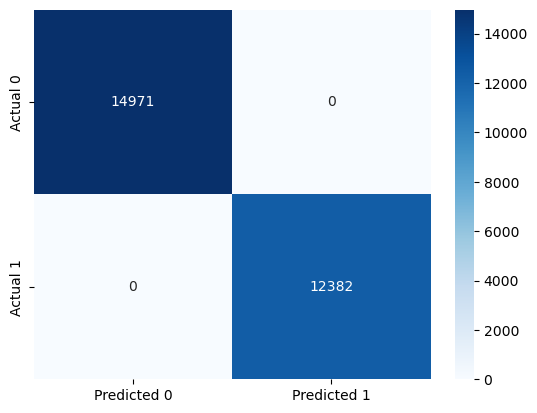

In [71]:
# Performance metrics computation 
#train
#Computing the accuracy
y_pred = dt_model1.predict(X_train_encoded)
print("Accuracy: ",accuracy_score(y_pred, y_train)*100)  

#Computing the ROC-AUC
y_pred_prob = dt_model1.predict_proba(X_train_encoded)[:,1]
fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Accuracy:  81.81685196021064
ROC-AUC:  0.8167481767237198
Precision:  0.797427652733119
Recall:  0.8018105399288716


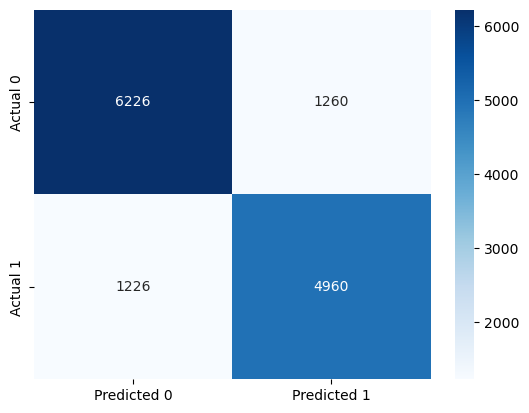

In [68]:
#test
#Computing the accuracy
y_pred = dt_model1.predict(X_test_encoded)
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
y_pred_prob = dt_model1.predict_proba(X_test_encoded)[:,1]
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

In [132]:
# Course Grid Search
param_grid = {    
    'max_depth': range(5,51,5),
    'max_leaf_nodes': range(5,3400,100),
    'max_features': range(10, 180, 10)
}

#Grid search to optimize parameter values
skf = StratifiedKFold(n_splits=30)#The folds are made by preserving the percentage of samples for each class.

#Minimizing FNR is equivalent to maximizing recall
grid_search = RandomizedSearchCV(DecisionTreeClassifier(random_state=1), param_grid, scoring=['precision','recall'], 
                           refit="recall", cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X_train_encoded, y_train)

# make the predictions
y_pred = grid_search.predict(X_test_encoded)


Fitting 30 folds for each of 10 candidates, totalling 300 fits


In [133]:
print('Train accuracy : %.3f'%grid_search.best_estimator_.score(X_train_encoded, y_train))
print('Test accuracy : %.3f'%grid_search.best_estimator_.score(X_test_encoded, y_test))
print('Train accuracy : %.3f'%grid_search.best_estimator_.score(X_train_encoded, y_train))
print('Test accuracy : %.3f'%grid_search.best_estimator_.score(X_test_encoded, y_test))
print('Best accuracy Through Grid Search : %.3f'%grid_search.best_score_)

y_train_pred = grid_search.best_estimator_.predict(X_train_encoded)
train_recall = recall_score(y_train, y_train_pred)
print('Train recall : %.3f' % train_recall)
y_test_pred = grid_search.best_estimator_.predict(X_test_encoded)
test_recall = recall_score(y_test, y_test_pred)
print('Test recall : %.3f' % test_recall)

print('Best params for recall')
print(grid_search.best_params_)

Train accuracy : 0.929
Test accuracy : 0.853
Train accuracy : 0.929
Test accuracy : 0.853
Best accuracy Through Grid Search : 0.838
Train recall : 0.924
Test recall : 0.842
Best params for recall
{'max_leaf_nodes': 905, 'max_features': 170, 'max_depth': 40}


In [134]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_leaf_nodes,param_max_features,param_max_depth,params,split0_test_precision,split1_test_precision,...,split23_test_recall,split24_test_recall,split25_test_recall,split26_test_recall,split27_test_recall,split28_test_recall,split29_test_recall,mean_test_recall,std_test_recall,rank_test_recall
0,0.561082,0.096483,0.008646,0.006951,805,140,30,"{'max_leaf_nodes': 805, 'max_features': 140, '...",0.831683,0.835681,...,0.839806,0.834951,0.866505,0.815534,0.786408,0.822816,0.834951,0.834271,0.021055,3
1,0.300917,0.022990,0.004236,0.002587,2205,70,50,"{'max_leaf_nodes': 2205, 'max_features': 70, '...",0.818841,0.813364,...,0.827670,0.798544,0.847087,0.822816,0.803398,0.788835,0.791262,0.820137,0.022448,6


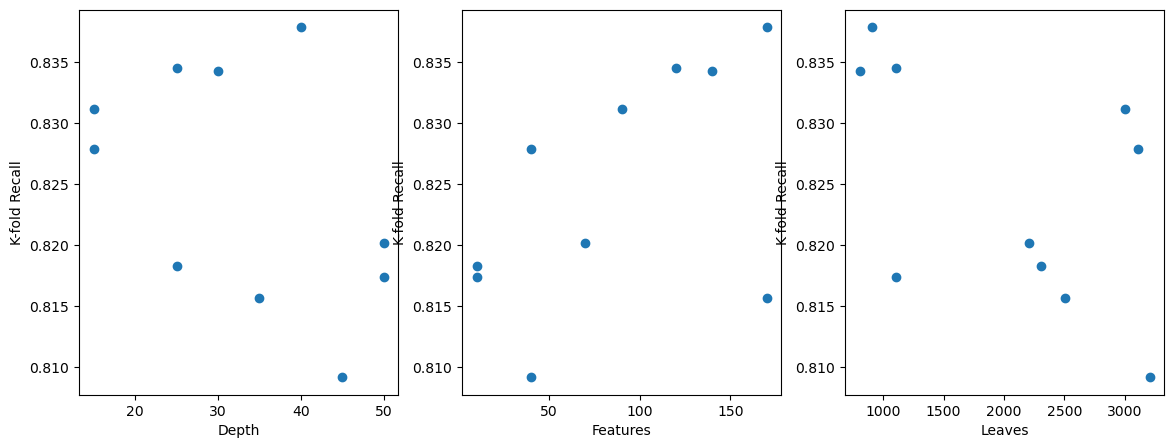

In [135]:
fig, axes = plt.subplots(1,3,figsize=(14,5))
plt.subplots_adjust(wspace=0.2)
axes[0].plot(cv_results.param_max_depth, cv_results.mean_test_recall, 'o')
axes[0].set_xlabel('Depth')
axes[0].set_ylabel('K-fold Recall')
axes[1].plot(cv_results.param_max_features, cv_results.mean_test_recall, 'o')
axes[1].set_xlabel('Features')
axes[1].set_ylabel('K-fold Recall');
axes[2].plot(cv_results.param_max_leaf_nodes, cv_results.mean_test_recall, 'o')
axes[2].set_xlabel('Leaves')
axes[2].set_ylabel('K-fold Recall');

In [136]:
#Finer Grid 
# From Course Grid {'max_leaf_nodes': 905, 'max_features': 170, 'max_depth': 40}
param_grid = {    
    'max_depth': range(38, 45,2),
    'max_leaf_nodes': range(900,910,2),
    'max_features': range(165, 175, 2)
}

#Grid search to optimize parameter values
import time as time
start_time = time.time()
skf = StratifiedKFold(n_splits=20)#The folds are made by preserving the percentage of samples for each class.

#Minimizing FNR is equivalent to maximizing recall
grid_search = RandomizedSearchCV(DecisionTreeClassifier(random_state=1), param_grid, scoring=['precision','recall'], 
                           refit="recall", cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X_train_encoded, y_train)

Fitting 20 folds for each of 10 candidates, totalling 200 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=20, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
                   param_distributions={'max_depth': range(38, 45, 2),
                                        'max_features': range(165, 175, 2),
                                        'max_leaf_nodes': range(900, 910, 2)},
                   refit='recall', scoring=['precision', 'recall'],
                   verbose=True)

In [137]:
print(grid_search.best_params_)

{'max_leaf_nodes': 900, 'max_features': 167, 'max_depth': 44}


Accuracy:  85.30573434757169
ROC-AUC:  0.8729105732791954
Precision:  0.831665872637764
Recall:  0.8465890720982865


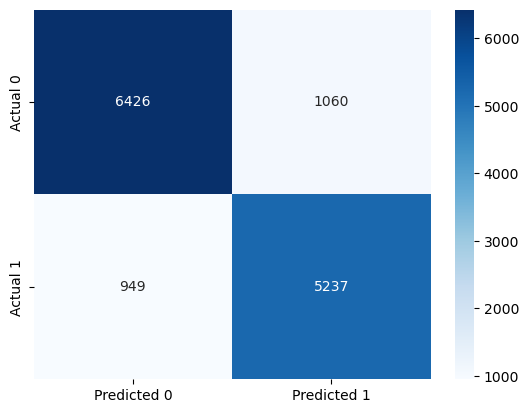

In [139]:
dt_final = grid_search.best_estimator_

# Performance metrics computation 
#Computing the accuracy
y_pred = dt_final.predict(X_test_encoded)
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
y_pred_prob = dt_final.predict_proba(X_test_encoded)[:,1]
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

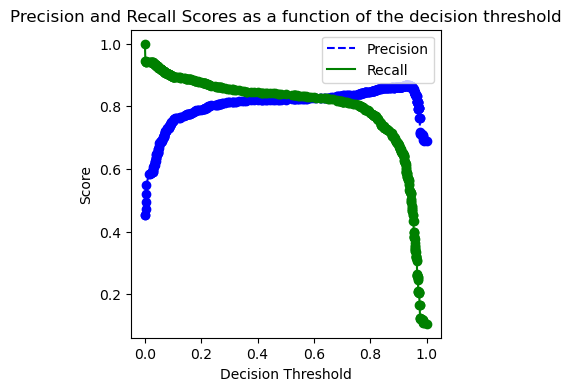

In [140]:
#threshold tuning 
cross_val_ypred = cross_val_predict(dt_final, X_train_encoded, 
                                              y_train, cv = 5, method = 'predict_proba')

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(4, 4))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

Accuracy:  92.73571454685043
ROC-AUC:  0.9710631692278037
Precision:  0.9128604337119708
Recall:  0.9281214666451301


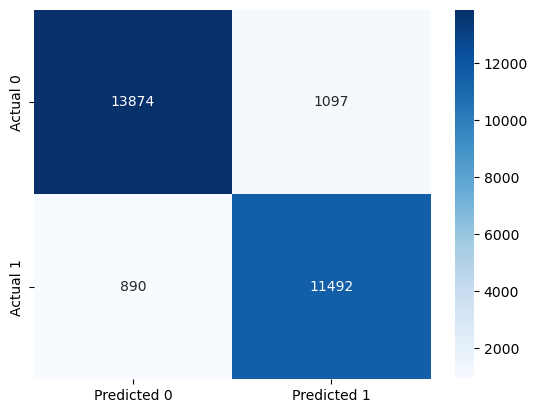

In [141]:
#threshold tuning 
#train
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.5

y_pred_prob = dt_final.predict_proba(X_train_encoded)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_train)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Accuracy:  85.30573434757169
ROC-AUC:  0.8729105732791954
Precision:  0.831665872637764
Recall:  0.8465890720982865


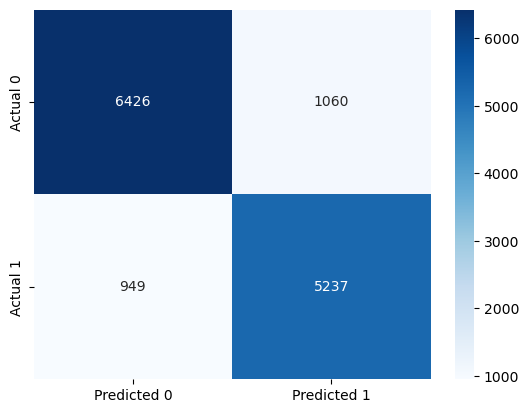

In [149]:
#threshold tuning 
#test
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.5

y_pred_prob = dt_final.predict_proba(X_test_encoded)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

# Decision Tree with Cost Complexity Tuning

In [150]:
# decision tree cost complexity pruning 
ccp_model = DecisionTreeClassifier(random_state = 1)#model without any restrictions
path= ccp_model.cost_complexity_pruning_path(X_train_encoded, y_train)# Compute the pruning path during Minimal Cost-Complexity Pruning.

In [151]:
alphas=path['ccp_alphas']
len(alphas)

1465

In [152]:
#Grid search to optimize parameter values
skf = StratifiedKFold(n_splits=30)
grid_search = RandomizedSearchCV(DecisionTreeClassifier(random_state = 1), param_distributions = {'ccp_alpha':alphas}, 
                                                  scoring=['precision','recall','accuracy'], 
                                                  refit="recall", cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X_train_encoded, y_train)

# make the predictions
y_pred = grid_search.predict(X_test_encoded)
print('Best params for recall')
print(grid_search.best_params_)

Fitting 30 folds for each of 10 candidates, totalling 300 fits
Best params for recall
{'ccp_alpha': 0.00012957283640572484}


In [153]:
# Model with the optimal value of 'ccp_alpha'
ccp_model = DecisionTreeClassifier(ccp_alpha=0.00012957283640572484,random_state=1)
ccp_model.fit(X_train_encoded, y_train)

DecisionTreeClassifier(ccp_alpha=0.00012957283640572484, random_state=1)

Accuracy:  86.21269748390871
ROC-AUC:  0.9277740477126437
Precision:  0.8419462553665129
Recall:  0.8559650824442289


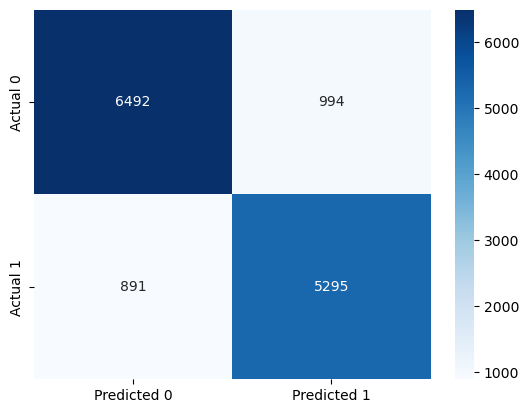

In [154]:
# Performance metrics computation 
#Computing the accuracy
y_pred = ccp_model.predict(X_test_encoded)
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
y_pred_prob = ccp_model.predict_proba(X_test_encoded)[:,1]
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

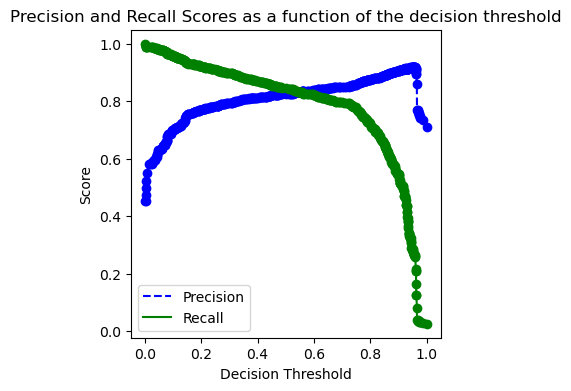

In [155]:
#threshold tuning 
cross_val_ypred = cross_val_predict(ccp_model, X_train_encoded, 
                                              y_train, cv = 5, method = 'predict_proba')

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(4, 4))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

Accuracy:  88.31572405220633
ROC-AUC:  0.9459728155206566
Precision:  0.8697472226694574
Recall:  0.8725569374899047


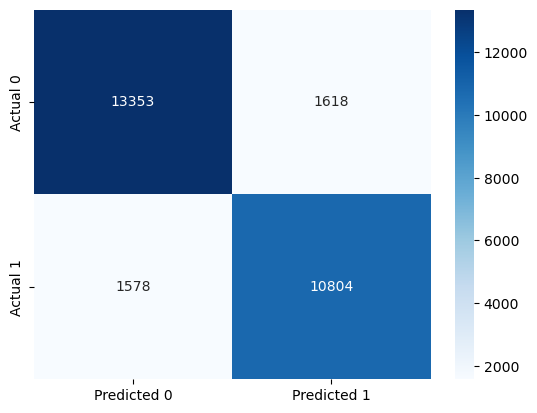

In [160]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.55

y_pred_prob = ccp_model.predict_proba(X_train_encoded)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_train)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Accuracy:  86.13955529549445
ROC-AUC:  0.9277740477126437
Precision:  0.8444373093594477
Recall:  0.850307145166505


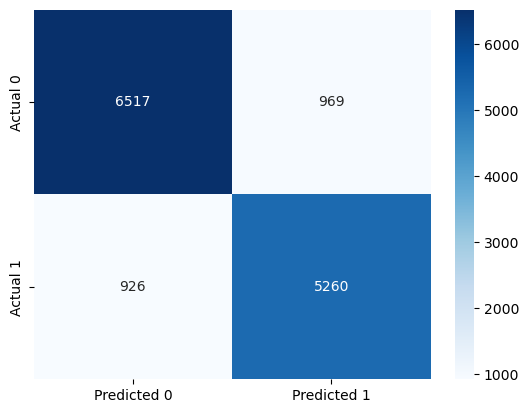

In [164]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.55

y_pred_prob = ccp_model.predict_proba(X_test_encoded)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

# Random Forest

In [116]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
accuracy_score, precision_score, confusion_matrix, mean_squared_error, r2_score

import itertools as it
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
accuracy_score, precision_score, confusion_matrix, mean_squared_error, r2_score

import itertools as it
import time as time

In [190]:
# Random Forest Base Model 
rf_model1 = RandomForestClassifier(random_state=1)
rf_model1.fit(X_train_encoded, y_train)
y_pred = rf_model1.predict(X_test_encoded)
print(accuracy_score(y_test, y_pred), recall_score(y_test, y_pred))

0.8765359859566998 0.8839314581312642


In [186]:
# Feature Importance 
feature_importance = rf_model1.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train_encoded.columns, 'Importance': feature_importance})
feature_importance_df.head(10)

,Feature,Importance
0,age,0.080431
1,wage_hr,0.006333
2,cap_gain,0.028508
3,cap_loss,0.008877
4,dividend,0.058250
5,inst_weight,0.043712
6,num_ppl_worked,0.034338
7,weeks_worked,0.061615
8,class_ Federal government,0.001915
9,class_ Local government,0.002234


In [211]:
# Drop features with importance less than 0.001
imp_features = feature_importance_df[feature_importance_df['Importance'] >= 0.001]['Feature']
X_train_filtered = X_train_encoded[imp_features]
X_test_filtered = X_test_encoded[imp_features]
X_train_filtered.shape

(27353, 159)

In [220]:
# Random Forest Base Model with important features
rf_model1 = RandomForestClassifier(random_state=1)
rf_model1.fit(X_train_encoded, y_train)
y_pred = rf_model1.predict(X_test_encoded)
print(accuracy_score(y_test, y_pred), recall_score(y_test, y_pred))

0.8765359859566998 0.8839314581312642


In [230]:
#Course Grid
parameters = {'max_depth': range(5,51,5),
              'max_leaf_nodes': range(5,3400,100),
              'max_features': range(10, 180, 10), 
              'n_estimators': range(100, 501, 100),
             'max_samples':[0.25,0.5,0.75]}
cv = KFold(n_splits = 20,shuffle=True,random_state=1)
rf_model2 = RandomizedSearchCV(RandomForestClassifier(random_state=1, n_jobs=-1), parameters, 
                     scoring=['accuracy','recall'], refit='recall',
                            cv=cv, n_jobs=-1, verbose = True)
rf_model2.fit(X_train_encoded, y_train)
print("Best Accuracy:", rf_model2.best_score_, "Best Parameters:",rf_model2.best_params_)

Fitting 20 folds for each of 10 candidates, totalling 200 fits
Best Accuracy: 0.8928916339397732 Best Parameters: {'n_estimators': 400, 'max_samples': 0.5, 'max_leaf_nodes': 3205, 'max_features': 10, 'max_depth': 20}


In [231]:
#Finer Grid 
# From Course Grid {'n_estimators': 400, 'max_samples': 0.5, 'max_leaf_nodes': 3205, 'max_features': 10, 'max_depth': 20}
parameters = {'max_depth':range(18,23),
              'max_leaf_nodes':range(3200,3209,3),
              'max_features':range(8,12), 
             'max_samples':[0.45, 0.5, 0.55]}
cv = KFold(n_splits = 5,shuffle=True,random_state=1)
rf_model2 = RandomizedSearchCV(RandomForestClassifier(random_state=1, n_jobs=-1, n_estimators = 400), parameters, 
                     scoring=['accuracy','recall'], refit='recall',
                            cv=cv, n_jobs=-1, verbose = True)
rf_model2.fit(X_train_encoded, y_train)
print("Best Accuracy:", rf_model2.best_score_, "Best Parameters:",rf_model2.best_params_)#Course Grid

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Accuracy: 0.8951373962868988 Best Parameters: {'max_samples': 0.5, 'max_leaf_nodes': 3203, 'max_features': 9, 'max_depth': 19}


Accuracy:  87.14160327677004
ROC-AUC:  0.9462636213959991
Precision:  0.8294642857142858
Recall:  0.9010669253152279


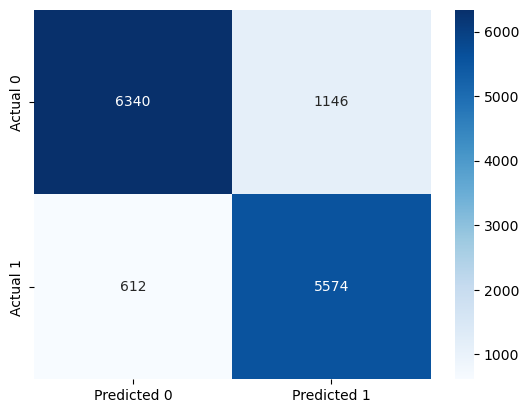

In [232]:
rf_final = rf_model2.best_estimator_

# Performance metrics computation 
#Computing the accuracy
y_pred = rf_final.predict(X_test_encoded)
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
y_pred_prob = rf_final.predict_proba(X_test_encoded)[:,1]
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

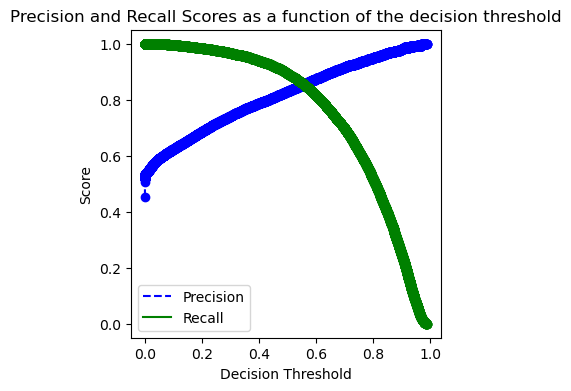

In [233]:
#threshold tuning 
cross_val_ypred = cross_val_predict(rf_final, X_train_encoded, 
                                              y_train, cv = 5, method = 'predict_proba')

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(4, 4))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

Accuracy:  92.08496325814353
ROC-AUC:  0.9791866331656914
Precision:  0.9040575812702681
Recall:  0.9231141980293975


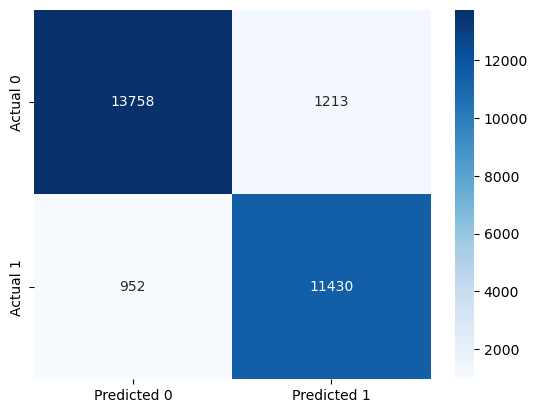

In [235]:
# train
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.55

y_pred_prob = rf_final.predict_proba(X_train_encoded)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_train)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Accuracy:  87.19280280866003
ROC-AUC:  0.9462636213959991
Precision:  0.8524876808138611
Recall:  0.8669576462980925


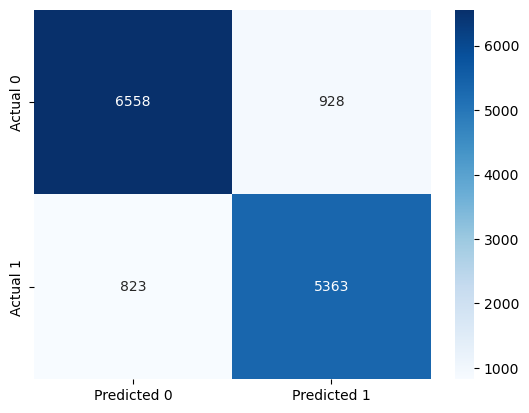

In [236]:
#test 
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.55

y_pred_prob = rf_final.predict_proba(X_test_encoded)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

In [238]:
# Feature Importance 
feature_scores = pd.Series(rf_final.feature_importances_, index=X_train_encoded.columns).sort_values(ascending=False)
feature_scores

weeks_worked                         0.071213
dividend                             0.058113
age                                  0.056701
num_ppl_worked                       0.049640
tax_filer_stat_ Nonfiler             0.030873
                                       ...   
ind_code_det_24                      0.000481
occ_code_maj_ Protective services    0.000468
ind_code_det_31                      0.000453
race_ Other                          0.000434
hisp_origin_ Puerto Rican            0.000410
Length: 189, dtype: float64